In [6]:
import itertools
import math
import struct

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing

pd.options.display.max_rows = 2000
pd.options.display.max_columns = 1000
pd.options.display.width = 1500

In [7]:
def read_idx(filename):
    with open(filename, "rb") as f:
        zero, data_type, dims = struct.unpack(">HBB", f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


train_data = read_idx("./train-images.idx3-ubyte")
train_label = read_idx("./train-labels.idx1-ubyte")
test_data = read_idx("./t10k-images.idx3-ubyte")
test_label = read_idx("./t10k-labels.idx1-ubyte")

## Naive Bayes - Discrete mode
---
### Function of discrete mode:
- The equation is $$max\hspace{0.3cm}posterior = \frac{\Pr(x|\theta) \Pr(\theta)}{\Pr(x)} = \underset{j}{\operatorname{argmax}} \frac{\Pi_{i=0}^{783}\frac{x_i}{n_{ji}} \times \pi_{ji}}{\Pr(x)}$$
- $\pi_{ji}$ is the prior = $\Pr[y=j] ,\hspace{1cm} 0 \leq j \leq 9$

In [8]:
class NaiveBayes_Dis():
    def __init__(self, train_data, train_label):
        self.train_label = train_label
        # How many numbers of digit 0~9
        self.class_count = [0 for _ in range(10)]

        # pixel_data[digit][pixel][bins] with pseudo count
        self.pixel_data = [[[10**-5 for _ in range(32)]
                            for _ in range(28 * 28)] for _ in range(10)]
        self.__buildTrainingData(train_data)

    def mapping(self, value):
        """
        For discrete mode: map 0~255 to 0~31
        """
        if value == 255:
            return 31
        else:
            return math.floor(value / 255 * 32)

    def flatten(self, data):
        flatten_data = []
        for i in range(len(data)):
            flatten_data.append(
                [item for sublist in data[i] for item in sublist])
        return flatten_data

    def __buildTrainingData(self, data):
        """
        For discrete mode: parse training data and save to dis_pixel_data[digit][pixel][bin]
        """
        vec = np.vectorize(self.mapping)
        data = vec(data)
        # flatten_data
        flatten_data = self.flatten(data)
        # Build class_count and pixel_data
        # class_count[digit]
        # pixel_data[digit][pixel][bin]
        for i, image in enumerate(flatten_data, 0):
            self.class_count[self.train_label[i]] += 1
            for pixel in range(len(image)):
                self.pixel_data[self.train_label[i]][pixel][image[pixel]] += 1

    def scale(self, posterior):
        posterior = preprocessing.minmax_scale(posterior)
        posterior = [i / posterior.sum() for i in posterior]
        return posterior

    def predict(self, test_data, test_label):
        vec = np.vectorize(self.mapping)
        test_data = vec(test_data)
        flatten_test_data = self.flatten(test_data)
        posterior = [np.zeros(10) for _ in range(len(flatten_test_data))]
        predict = []
        for i, img in enumerate(flatten_test_data, 0):
            for num in range(10):
                for pixel in range(784):
                    posterior[i][num] += np.log(
                        self.pixel_data[num][pixel][img[pixel]] /
                        self.class_count[num])
                posterior[i][num] += np.log(self.class_count[num] / 60000)
            predict.append(np.argmax(posterior[i]))
        scaled_posterior = []
        for post in posterior:
            scaled_posterior.append(self.scale(post))
        return scaled_posterior, predict

### Discrete mode: accuracy evaluate and guess


In [9]:
dis_result = NaiveBayes_Dis(train_data, train_label)
dis_post, dis_pred = dis_result.predict(test_data, test_label)

In [10]:
def discrete_output():
    # test cases
    for index in [0, 123]:
        print("Posterior (in log scale):")
        for i in range(10):
            print("%d: %f" % (i, dis_post[index][i]))
        print("Prediction: %d, Ans: %d" % (dis_pred[index], test_label[index]))
        print("")
    acc = metrics.accuracy_score(test_label, dis_pred)
    print("Accuracy: %f\nError rate: %f" % (acc, 1 - acc))


discrete_output()

Posterior (in log scale):
0: 0.065078
1: 0.000000
2: 0.076065
3: 0.109349
4: 0.126210
5: 0.121189
6: 0.025718
7: 0.193801
8: 0.120319
9: 0.162271
Prediction: 7, Ans: 7

Posterior (in log scale):
0: 0.094045
1: 0.000000
2: 0.136274
3: 0.110903
4: 0.118802
5: 0.115062
6: 0.168596
7: 0.054142
8: 0.109765
9: 0.092411
Prediction: 6, Ans: 6

Accuracy: 0.850700
Error rate: 0.149300


In [22]:
def discrete_guess():
    guess = []
    for digit, pixel_bin in enumerate(dis_result.pixel_data, 1):
        digit = []
        for bins in pixel_bin:
            digit.append(int(sum(bins[0:16]) <= sum(bins[16:])))
        digit = np.reshape(digit, (28, 28))
        guess.append(digit)
    return guess


discrete_guess = discrete_guess()
guess_num = 4
print("Guess %d\n" % guess_num, pd.DataFrame(discrete_guess[guess_num]))

Guess 4
     0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
0    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
1    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
3    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
4    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
5    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
6    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
7    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

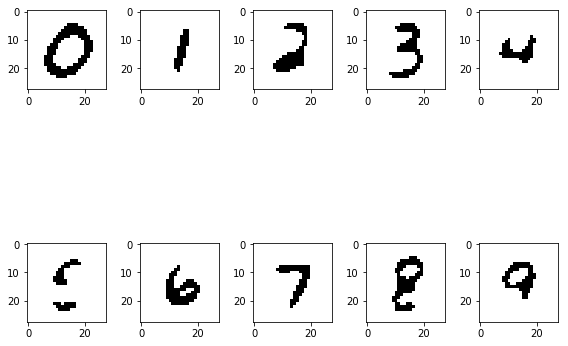

In [12]:
fig = plt.figure(figsize=(8, 8))
for num in range(10):
    sub = fig.add_subplot(2, 5, num + 1)
    sub.imshow(discrete_guess[num], cmap="Greys")
plt.tight_layout()
plt.show()

## Naive Bayes - Continuous mode
---
- $$Posterior = \frac{\Pr(x|c) \times Prior}{marginal}$$
- $\Pr(x|c)$ using Gaussian distribution

In [13]:
class NaiveBayes_Con():
    def __init__(self, train_data, train_label):
        self.train_label = train_label
        self.__buildTrainingData(train_data)

    def log_gaussian(self, x, mean, sigma):
        if sigma == 0:
            return 0
        elif x == mean:
            return 1
        return -1 / 2 * np.log(2 * math.pi) - 1 / 2 * np.log(sigma) - 1 / 2 * (
            x - mean)**2 / sigma

    def __buildTrainingData(self, train_data):
        self.class_count = [0 for _ in range(10)]
        flatten_data = self.flatten(train_data)
        self.pixel_data = [[[] for _ in range(784)] for _ in range(10)]
        for i, img in enumerate(flatten_data, 0):
            self.class_count[self.train_label[i]] += 1
            for pixel in range(784):
                self.pixel_data[self.train_label[i]][pixel].append(img[pixel])
        self.mean = [[] for _ in range(784)]
        self.variance = [[] for _ in range(784)]
        for num in range(10):
            for pixel in range(784):
                self.mean[num].append(np.mean(self.pixel_data[num][pixel]))
                self.variance[num].append(np.var(self.pixel_data[num][pixel]))

    def predict(self, test_data, test_label):
        flatten_data = self.flatten(test_data)
        posterior = [[] for _ in range(len(flatten_data))]
        predict = []
        for i, img in enumerate(flatten_data, 0):
            for num in range(10):
                post = 0
                for pixel in range(784):
                    likelihood = self.log_gaussian(img[pixel],
                                                   self.mean[num][pixel],
                                                   self.variance[num][pixel])
                    post += likelihood
                post += np.log(self.class_count[num] / 60000)
                posterior[i].append(post)
        for i in posterior:
            predict.append(np.argmax(i))
        return posterior, predict

    def flatten(self, data):
        flatten_data = []
        for i in range(len(data)):
            flatten_data.append(
                [item for sublist in data[i] for item in sublist])
        return flatten_data

In [14]:
result_con = NaiveBayes_Con(train_data, train_label)

In [15]:
con_post, con_pred = result_con.predict(test_data, test_label)

In [16]:
acc = metrics.accuracy_score(test_label, con_pred)
print("Accuracy: %f\nError rate: %f" % (acc, 1 - acc))

Accuracy: 0.648300
Error rate: 0.351700


In [17]:
def Gamma(x):
    return math.factorial(x - 1)


def Beta(x, y):
    return Gamma(x) * Gamma(y) / Gamma(a + b)


def betaDistribution(x, alpha, beta):
    return 1 / Beta(alpha, beta) * x**(alpha - 1) * (1 - x)**(beta - 1)


def Bin_Likelihood(p, n, m):
    return (math.factorial(n) / (math.factorial(m) * math.factorial(n - m))
            ) * p**m * (1 - p)**(n - m)

In [18]:
data = []
original_input = []
with open("test.txt", "r") as file:
    for lines in file.readlines():
        if lines[-1] == "\n":
            original_input.append(lines[:-1])
        else:
            original_input.append(lines)
        a = 0
        b = 0
        for i in range(len(lines)):
            if lines[i] == "0":
                b += 1
            elif lines[i] == "1":
                a += 1
        data.append([a, b])
# data[line][a, b]

In [24]:
# case 1: initial a = 0, b = 0
prior_a = 0
prior_b = 0
post_a = 0
post_b = 0
for i in range(len(original_input)):
    m = data[i][0]
    n = data[i][0] + data[i][1]
    p = m / n
    likelihood = Bin_Likelihood(p, n, m)
    print("case %d: %s" % (i + 1, original_input[i]))
    print("Likelihood: %f" % likelihood)
    print("Beta Prior: \ta = %d, b = %d" % (prior_a, prior_b))
    prior_a += data[i][0]
    prior_b += data[i][1]
    post_a = prior_a
    post_b = prior_b
    print("Beta Posterior: a = %d, b = %d" % (post_a, post_b))
    print("\n")

case 1: 0101010101001011010101
Likelihood: 0.168188
Beta Prior: 	a = 0, b = 0
Beta Posterior: a = 11, b = 11


case 2: 0110101
Likelihood: 0.293755
Beta Prior: 	a = 11, b = 11
Beta Posterior: a = 15, b = 14


case 3: 010110101101
Likelihood: 0.228605
Beta Prior: 	a = 15, b = 14
Beta Posterior: a = 22, b = 19


case 4: 0101101011101011010
Likelihood: 0.182869
Beta Prior: 	a = 22, b = 19
Beta Posterior: a = 33, b = 27


case 5: 111101100011110
Likelihood: 0.214307
Beta Prior: 	a = 33, b = 27
Beta Posterior: a = 43, b = 32


case 6: 101110111000110
Likelihood: 0.206598
Beta Prior: 	a = 43, b = 32
Beta Posterior: a = 52, b = 38


case 7: 1010010111
Likelihood: 0.250823
Beta Prior: 	a = 52, b = 38
Beta Posterior: a = 58, b = 42


case 8: 11101110110
Likelihood: 0.261968
Beta Prior: 	a = 58, b = 42
Beta Posterior: a = 66, b = 45


case 9: 01000111101
Likelihood: 0.236091
Beta Prior: 	a = 66, b = 45
Beta Posterior: a = 72, b = 50


case 10: 110100111
Likelihood: 0.273129
Beta Prior: 	a = 72, 

In [20]:
# case 2: initial a = 10, b = 1
prior_a = 10
prior_b = 1
post_a = 0
post_b = 0
for i in range(len(original_input)):
    m = data[i][0]
    n = data[i][0] + data[i][1]
    p = m / n
    likelihood = Bin_Likelihood(p, n, m)
    print("case %d: %s" % (i + 1, original_input[i]))
    print("Likelihood: %f" % likelihood)
    print("Beta Prior: \ta = %d, b = %d" % (prior_a, prior_b))
    prior_a += data[i][0]
    prior_b += data[i][1]
    post_a = prior_a
    post_b = prior_b
    print("Beta Posterior: a = %d, b = %d" % (post_a, post_b))
    print("\n")

case 1: 0101010101001011010101
Likelihood: 0.168188
Beta Prior: 	a = 10, b = 1
Beta Posterior: a = 21, b = 12


case 2: 0110101
Likelihood: 0.293755
Beta Prior: 	a = 21, b = 12
Beta Posterior: a = 25, b = 15


case 3: 010110101101
Likelihood: 0.228605
Beta Prior: 	a = 25, b = 15
Beta Posterior: a = 32, b = 20


case 4: 0101101011101011010
Likelihood: 0.182869
Beta Prior: 	a = 32, b = 20
Beta Posterior: a = 43, b = 28


case 5: 111101100011110
Likelihood: 0.214307
Beta Prior: 	a = 43, b = 28
Beta Posterior: a = 53, b = 33


case 6: 101110111000110
Likelihood: 0.206598
Beta Prior: 	a = 53, b = 33
Beta Posterior: a = 62, b = 39


case 7: 1010010111
Likelihood: 0.250823
Beta Prior: 	a = 62, b = 39
Beta Posterior: a = 68, b = 43


case 8: 11101110110
Likelihood: 0.261968
Beta Prior: 	a = 68, b = 43
Beta Posterior: a = 76, b = 46


case 9: 01000111101
Likelihood: 0.236091
Beta Prior: 	a = 76, b = 46
Beta Posterior: a = 82, b = 51


case 10: 110100111
Likelihood: 0.273129
Beta Prior: 	a = 82,